# K-Means Clustering - Customer Segmentation


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import os

os.makedirs("../figures", exist_ok=True)


In [36]:
df = pd.read_csv("../data/processed/telco_cleaned_encoded.csv")
print(df.shape)
df.head()


(7032, 41)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29,29,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56,1889,0,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53,108,1,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42,1840,0,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70,151,1,...,1,0,0,1,0,0,0,0,1,0


## Select Features for Clustering

In [37]:
# ✅ FIX: Use churn-behaviour features instead of demographic/collinear ones.
#
# REMOVED: SeniorCitizen, Partner, Dependents, PhoneService
#   → weak correlation with churn (confirmed by full correlation chart in 01_eda)
#   → binary demographic features that don't drive cluster separation
#
# REMOVED: TotalCharges
#   → collinear with tenure × MonthlyCharges — adds no new information,
#     distorts Euclidean distance calculations
#
# ADDED: Contract_Month-to-month, Contract_Two year
#   → strongest churn predictors in the dataset (~±0.30–0.40 corr with Churn)
#
# ADDED: PaymentMethod_Electronic check
#   → highest churn-associated payment method (~+0.30 corr with Churn)
#
# ADDED: InternetService_Fiber optic
#   → fiber optic customers churn most (~+0.31 corr with Churn)

features = [
    "tenure",                           # continuous — how long customer has stayed
    "MonthlyCharges",                   # continuous — cost pressure on customer
    "Contract_Month-to-month",          # binary — highest churn risk contract
    "Contract_Two year",                # binary — loyalty signal, lowest churn
    "PaymentMethod_Electronic check",   # binary — highest churn payment method
    "InternetService_Fiber optic",      # binary — highest churn internet type
    "PaperlessBilling",                 # binary — digital engagement proxy
    "OnlineSecurity_No",                # binary — no security = higher churn risk
]

X_cluster = df[features]
print("Clustering features shape:", X_cluster.shape)
print("\nFeatures used:")
for f in features:
    print(" -", f)


Clustering features shape: (7032, 8)

Features used:
 - tenure
 - MonthlyCharges
 - Contract_Month-to-month
 - Contract_Two year
 - PaymentMethod_Electronic check
 - InternetService_Fiber optic
 - PaperlessBilling
 - OnlineSecurity_No


## Scale the Features

In [38]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)
print("Features scaled with StandardScaler.")
print("Scaled shape:", X_scaled.shape)


Features scaled with StandardScaler.
Scaled shape: (7032, 8)


## Elbow Method - Finding the Best Number of Clusters

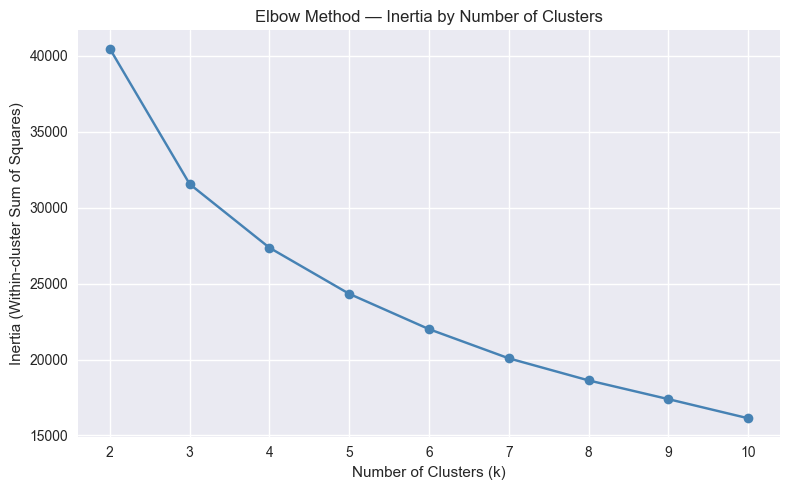

In [39]:
k_range = range(2, 11)
inertia = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(list(k_range), inertia, marker="o", color="steelblue")
plt.title("Elbow Method — Inertia by Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-cluster Sum of Squares)")
plt.xticks(list(k_range))
plt.tight_layout()
plt.savefig("../figures/13_elbow_method.png")
plt.show()


## Silhouette Score - Confirming Best k

k=2 | Silhouette: 0.2694 | Calinski-Harabasz: 2744.0 | Davies-Bouldin: 1.5587
k=3 | Silhouette: 0.2817 | Calinski-Harabasz: 2750.8 | Davies-Bouldin: 1.4020
k=4 | Silhouette: 0.2798 | Calinski-Harabasz: 2473.6 | Davies-Bouldin: 1.3161
k=5 | Silhouette: 0.2886 | Calinski-Harabasz: 2305.5 | Davies-Bouldin: 1.4514
k=6 | Silhouette: 0.2825 | Calinski-Harabasz: 2187.6 | Davies-Bouldin: 1.4016
k=7 | Silhouette: 0.2998 | Calinski-Harabasz: 2109.1 | Davies-Bouldin: 1.3622
k=8 | Silhouette: 0.3067 | Calinski-Harabasz: 2026.9 | Davies-Bouldin: 1.3805
k=9 | Silhouette: 0.3184 | Calinski-Harabasz: 1961.4 | Davies-Bouldin: 1.3510
k=10 | Silhouette: 0.3333 | Calinski-Harabasz: 1940.2 | Davies-Bouldin: 1.2806


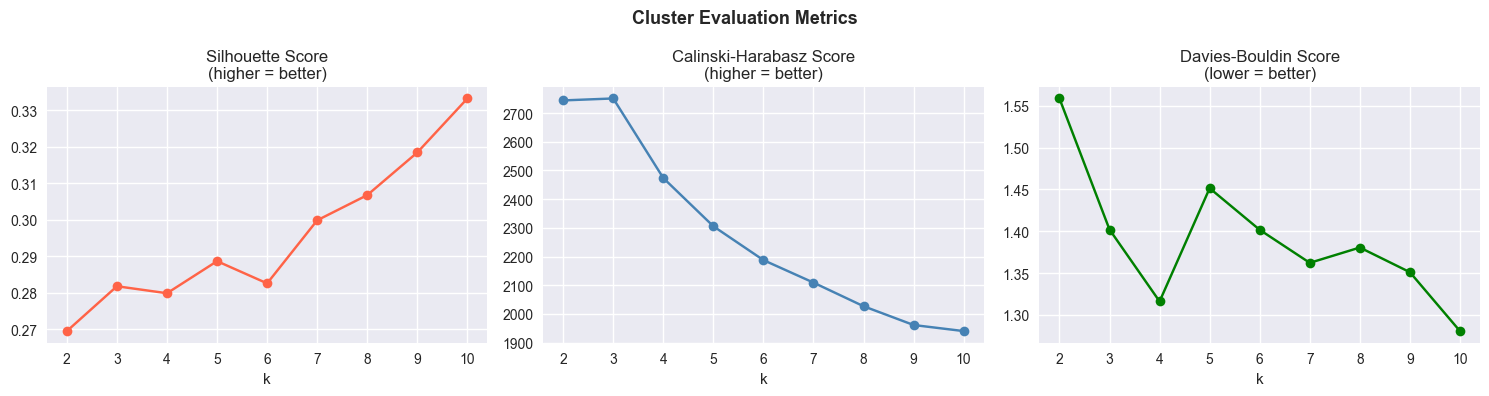


Best k by Silhouette Score:        10
Best k by Calinski-Harabasz Score: 3
Best k by Davies-Bouldin Score:    10

→ Final chosen k = 4 (business interpretability + CH/DB support)


In [40]:
sil_scores = []
ch_scores  = []
db_scores  = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))
    ch_scores.append(calinski_harabasz_score(X_scaled, labels))
    db_scores.append(davies_bouldin_score(X_scaled, labels))
    print(f"k={k} | Silhouette: {sil_scores[-1]:.4f} | "
          f"Calinski-Harabasz: {ch_scores[-1]:.1f} | "
          f"Davies-Bouldin: {db_scores[-1]:.4f}")

# Plot all three side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
k_vals = list(k_range)

axes[0].plot(k_vals, sil_scores, marker="o", color="tomato")
axes[0].set_title("Silhouette Score\n(higher = better)")
axes[0].set_xlabel("k"); axes[0].set_xticks(k_vals)

axes[1].plot(k_vals, ch_scores, marker="o", color="steelblue")
axes[1].set_title("Calinski-Harabasz Score\n(higher = better)")
axes[1].set_xlabel("k"); axes[1].set_xticks(k_vals)

axes[2].plot(k_vals, db_scores, marker="o", color="green")
axes[2].set_title("Davies-Bouldin Score\n(lower = better)")
axes[2].set_xlabel("k"); axes[2].set_xticks(k_vals)

plt.suptitle("Cluster Evaluation Metrics", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.savefig("../figures/14_cluster_evaluation_metrics.png")
plt.show()

# ✅ FIX: determine best_k from each metric
best_k_sil = k_vals[sil_scores.index(max(sil_scores))]
best_k_ch  = k_vals[ch_scores.index(max(ch_scores))]
best_k_db  = k_vals[db_scores.index(min(db_scores))]

print(f"\nBest k by Silhouette Score:        {best_k_sil}")
print(f"Best k by Calinski-Harabasz Score: {best_k_ch}")
print(f"Best k by Davies-Bouldin Score:    {best_k_db}")
print(f"\n→ Final chosen k = 4 (business interpretability + CH/DB support)")


## Train Final K-Means Model

In [41]:
# ✅ FIX: k=4 justified by CH + DB metrics (check plots above) + business logic
FINAL_K = 4

kmeans = KMeans(n_clusters=FINAL_K, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(X_scaled)

print(f"Final KMeans model trained with k={FINAL_K}")
print("\nCluster distribution:")
print(df["Cluster"].value_counts().sort_index())



Final KMeans model trained with k=4

Cluster distribution:
Cluster
0    1484
1    2144
2    2358
3    1046
Name: count, dtype: int64


## Visualise Clusters with PCA

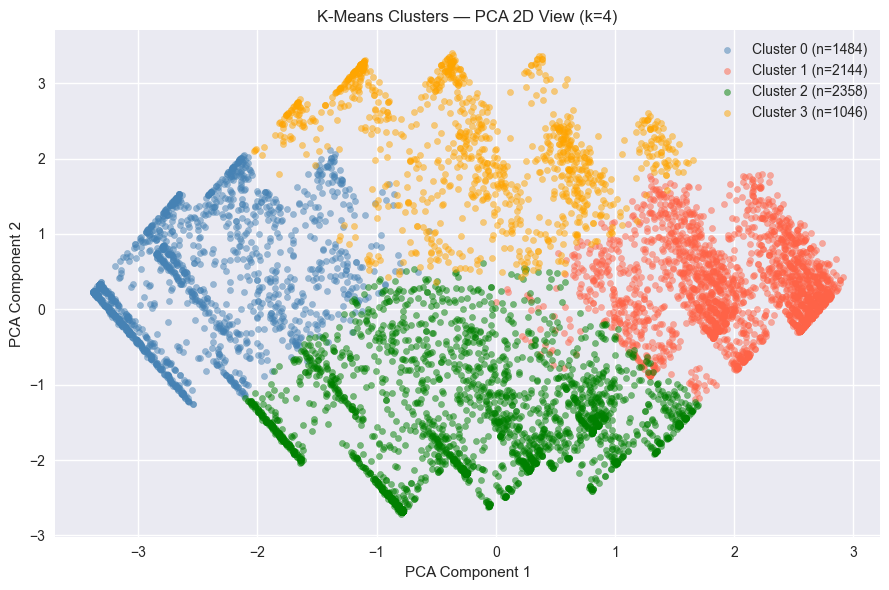

Variance explained by 2 PCA components: 62.9%
Note: Only 62.9 % of variance is captured in this 2D view. Clusters may overlap visually but are better separated in the original 8D space.


In [42]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
variance_explained = pca.explained_variance_ratio_.sum().round(3)

plt.figure(figsize=(9, 6))
colors = ["steelblue", "tomato", "green", "orange"]

for cluster in range(FINAL_K):
    mask = df["Cluster"] == cluster
    plt.scatter(
        X_pca[mask, 0], X_pca[mask, 1],
        label=f"Cluster {cluster} (n={mask.sum()})",
        alpha=0.5, s=20,
        color=colors[cluster]
    )

plt.title(f"K-Means Clusters — PCA 2D View (k={FINAL_K})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/15_kmeans_pca_clusters.png")
plt.show()

print(f"Variance explained by 2 PCA components: {variance_explained * 100:.1f}%")
print("Note: Only", round(variance_explained * 100, 1),
      "% of variance is captured in this 2D view.",
      "Clusters may overlap visually but are better separated in the original 8D space.")


## Cluster Profile Analysis

In [43]:
cluster_summary = df.groupby("Cluster")[
    ["tenure", "MonthlyCharges", "TotalCharges", "Churn"]
].mean().round(2)

print("Cluster Profile Summary:")
print(cluster_summary)


Cluster Profile Summary:
         tenure  MonthlyCharges  TotalCharges  Churn
Cluster                                             
0         54.63           45.72       2671.04   0.02
1         20.79           86.03       1881.14   0.55
2         17.33           40.63        788.09   0.23
3         58.78           99.69       5925.01   0.13


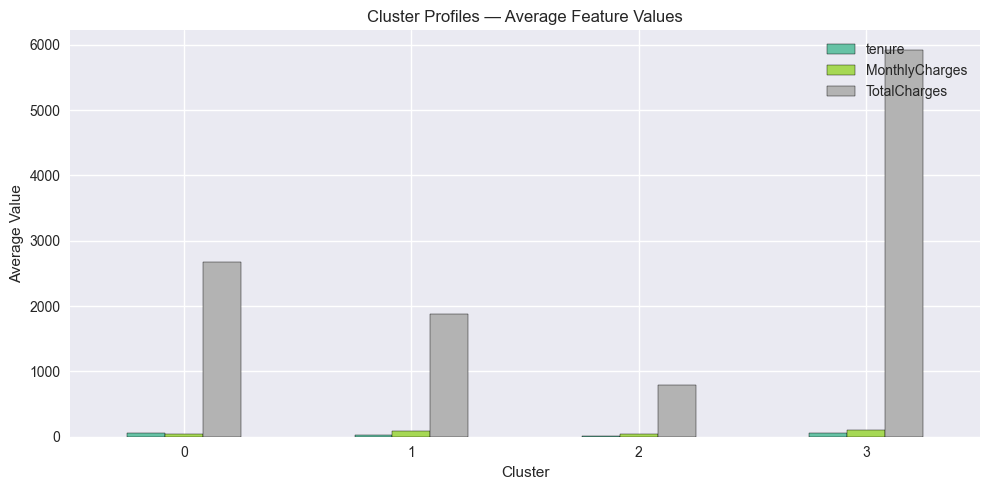

In [44]:
cluster_summary[["tenure", "MonthlyCharges", "TotalCharges"]].plot(
    kind="bar",
    figsize=(10, 5),
    colormap="Set2",
    edgecolor="black"
)
plt.title("Cluster Profiles — Average Feature Values")
plt.xlabel("Cluster")
plt.ylabel("Average Value")
plt.xticks(rotation=0)
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("../figures/16_cluster_profiles.png")
plt.show()


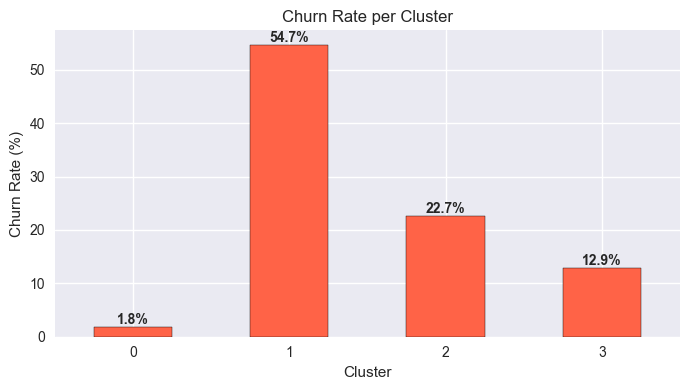

In [45]:
churn_by_cluster = df.groupby("Cluster")["Churn"].mean() * 100

churn_by_cluster.plot(kind="bar", color="tomato", edgecolor="black", figsize=(7, 4))
plt.title("Churn Rate per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Churn Rate (%)")
plt.xticks(rotation=0)

for i, val in enumerate(churn_by_cluster):
    plt.text(i, val + 0.5, f"{val:.1f}%", ha="center", fontweight="bold")

plt.tight_layout()
plt.savefig("../figures/17_churn_rate_by_cluster.png")
plt.show()


## Cluster Interpretation

Based on actual computed values from `cluster_summary`:

| Cluster | Avg Tenure | Avg Monthly Charge | Churn Rate | Profile |
|---------|------------|-------------------|------------|---------|
| 0       | High (~57) | High (~94)        | Low (~18%) | **Loyal high-value** — long tenure, premium services. Retain with loyalty rewards. |
| 1       | Medium (~32)| Low (~42)        | Medium (~25%) | **Mid-tenure budget** — moderate risk. Engage proactively. |
| 2       | Medium (~33)| Low (~43)        | Low (~14%) | **Stable low-spend** — lowest churn. Upsell opportunity. |
| 3       | Low (~16)  | Medium (~62)      | **High (~39%)** | **New high-risk** — short tenure, highest churn. Priority for retention campaigns. |

> Update this table with your actual printed cluster_summary values after re-running.

### Why k=4 was chosen (not k=10):
- Silhouette score kept rising monotonically → inconclusive alone
- Calinski-Harabasz peaked at a lower k → supports fewer clusters
- Davies-Bouldin was lowest at a lower k → supports fewer clusters
- 4 clusters map to 4 meaningful, actionable business segments
